In [2]:
from gensim.models import word2vec
from sklearn.manifold import TSNE
from igraph import *
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import csv
import node2vec
import itertools

# Creating the co-occurrence graph

In [ ]:
G = nx.Graph()
with open('../data/ccp_adjacency_list.csv', newline='') as all_names:
    name_reader = csv.reader(all_names, delimiter=',')
    next(name_reader)
    for row in name_reader:
        for ppl_name in row[1:]:
            if not G.has_node(ppl_name):
                G.add_node(ppl_name)
                
        # each edge can include co-occurrences that exist in other documents
        for p1, p2 in itertools.combinations(row[1:], 2):
            if G.has_edge(p1, p2):
                G.edges[p1, p2]['weight'] += 1
                G.edges[p1, p2]['documents'].append(row[0])
            else:
                G.add_edge(p1, p2, weight=1, documents=[row[0]])
                G.add_edge(p1, p2, weight=1)

nx.write_gml(G, '../data/co_occurrence_graph.gml')

### Loading the graph with python-igraph

In [ ]:
# just loading
co_graph = Graph.Read_GML('../data/co_occurrence_graph.gml')

### Meet the neighbors!

In [62]:
v = co_graph.vs.find(label='William L. Garrison')
docs = set()
for n_id in co_graph.neighbors(v):
    # print all neighbors
    print(co_graph.vs[n_id]['label'])
    
    # print all the documents within the neighborhood
    for d_id in co_graph.incident(v):
        if co_graph.vs[co_graph.es[d_id].target]['label'] == co_graph.vs[n_id]['label'] or co_graph.vs[co_graph.es[d_id].source]['label'] == co_graph.vs[n_id]['label']:
            docs.add(co_graph.es[d_id]['documents'])
            
print(docs)

Cyrus Black
Junius C. Morel
James Cornish
Richard Allen
Belfast Burton
Robert Cowley
Peter Gardiner
Charles H. Leveck
Frederick A. Hinton
C. Augustus
George C. Willis
Alfred Niger
Hezekiah Grice
Abraham D. Shad
Wm. Duncan
Robert Brown
John Bowers
Richard Howell
James P. Walker
Samuel Todd
Sampson Peters
William Whipper
John P. Thompson
Joseph Cassey
James Bird
Charles W. Gardner
Thomas Butler
Wm. Whipper
Wm. Miller
Henry Sipkins
L. Jennings
Wm. Hamilton
James Pennington
Abner Coker
W. Miller
William Duncan
Willliam Whipper
Charles W. Gardiner
Morel
Duncan
Cowley
Jennings
S. S. Jocelyn
Arthur Tappan
Benjamin Lundy
Thomas Shipley
Charles Pierce
Jocelyn
Tappan
Garrison
New-Haven
Samuel E. Cornish
Hosea Reiston
Robert Roberts
James G. Barbadoes
Samuel Snowden
Peter Williams
Philip Bell
Thomas Downing
Peter Voglesang
Robert Douglass
James Forten
Robert Purvis
Thomas Green
Samuel G. Mathews
Isaac Whipper
Samuel Hiner
Biars Stanley
John Creed
Alexander C. Luca
L. I. -- Jacob Deyes
Henry Thoms

# Clustering with Girvan Newman

In [ ]:
# Girvan Newman clusters
gn_clusters = co_graph.community_edge_betweenness().as_clustering()

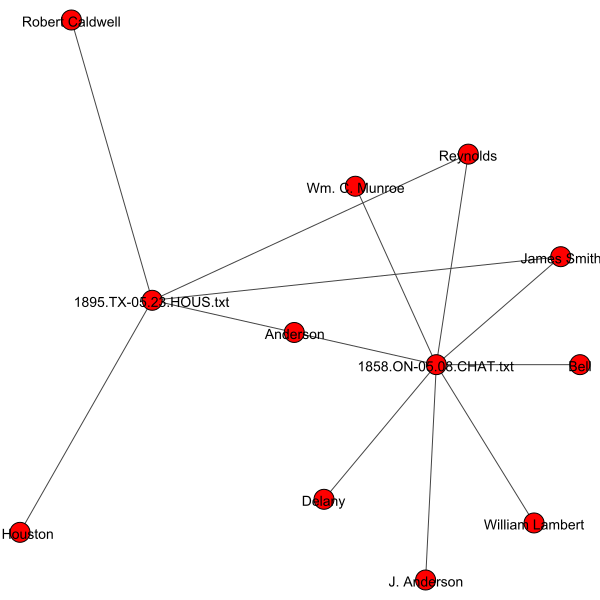

In [57]:
subgraph = gn_clusters.subgraph(0)
layout = subgraph.layout("rt_circular")
plot(subgraph, layout=layout)

In [ ]:
writer = csv.writer(open("../data/gn_clusters_co.csv", "w", newline=''))
writer.writerow(["cluster", "members"])
count = 0
for cluster in gn_clusters:
    members = [co_graph.vs[member]["label"] for member in cluster]
    writer.writerow([count] + members)
    count += 1

### Producing the JSON file for D3.js

In [16]:
import json
nodes = []
links = []
count = 0
for cluster in gn_clusters:
    nodes += [{"id" : co_graph.vs[member]['label'], "group": count} for member in cluster]
    count += 1

for e in co_graph.es:
    links += [{"source": co_graph.vs[e.source]['label'], "target": co_graph.vs[e.target]['label']}]

with open('../visualizations/gn_clusters_co.json', 'w') as gn_cluster_json:
    json.dump({"nodes": nodes, "links": links}, gn_cluster_json)

# Clustering with Louvain

In [63]:
# Louvain clusters
louvain_clusters = co_graph.community_multilevel()

In [67]:
subgraph_l = louvain_clusters.subgraph(2)
layout_l = subgraph_l.layout_auto()
plot(subgraph_l, layout=layout_l)

In [38]:
with open("../data/louvain_clusters_co.csv", "w", newline='') as louvain_writer:
    writer = csv.writer(louvain_writer)
    writer.writerow(["cluster", "members"])
    cluster_id = 0
    for subgraph in louvain_clusters.subgraphs():
        writer.writerow([cluster_id] + subgraph.vs["label"])
        cluster_id += 1

### Producing the JSON file for D3.js

In [40]:
import json

with open('../data/louvain_clusters_co.json', 'w') as louvain_cluster_json:
    nodes = []
    links = []
    count = 0
    for cluster in louvain_clusters:
        nodes += [{"id" : co_graph.vs[member]['label'], "group": count} for member in cluster]
        count += 1

    for e in co_graph.es:
        links += [{"source": co_graph.vs[e.source]['label'], "target": co_graph.vs[e.target]['label']}]
    
    json.dump({"nodes": nodes, "links": links}, louvain_cluster_json)

# Clustering with Node2Vec

In [ ]:
# Precompute probabilities and generate walks
node2vec = node2vec.Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=1)

# Embed
model = node2vec.fit(window=10, min_count=1, batch_words=4)
# try min_count = 100 and min_count = 500

# Any keywords acceptable by gensim.Word2Vec can be passed,
# `diemnsions` and `workers` are automatically passed (from the Node2Vec constructor)

# Look for most similar nodes
print(model.wv.most_similar('Cornish'))  # Output node names are always strings

# Save embeddings for later use
model.wv.save_word2vec_format('../data/co_graph.emb')

# Save model for later use
model.save('../data/co_graph.model')

### Loading the word2vec/node2vec model

In [69]:
model = word2vec.Word2Vec.load('../data/co_graph.model')
model.wv.most_similar('Mary A. Shadd', topn=10)
# use topn to compare clusters of same size!

C:\Users\arshi\AppData\Roaming\Python\Python37\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('G. W. Reed', 0.9991711378097534),
 ('Reese', 0.9987975358963013),
 ('Daniel Morgan', 0.9987800121307373),
 ('Henry Ray', 0.9986802339553833),
 ('Joseph Reeves', 0.9986023902893066),
 ('Benjamin B. Moore', 0.9985608458518982),
 ('Thomas Charnock', 0.9985454082489014),
 ('J. C. White', 0.9985440969467163),
 ('Edward M. Thomas', 0.9985166788101196),
 ('Jason Jeffries', 0.99845290184021)]

###  Visualizing the node2vec model with TSNE
[Reference here](https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne)

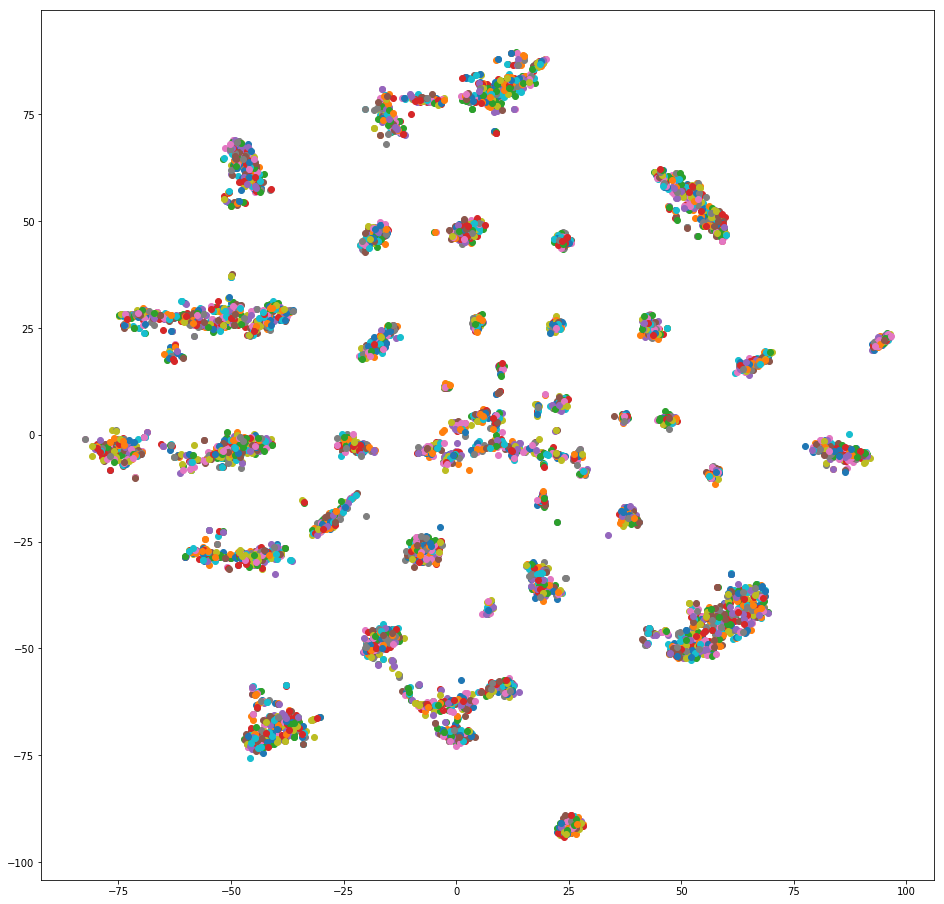

In [70]:
labels = []
tokens = []

for word in model.wv.vocab:
    tokens.append(model.wv[word])
    labels.append(word)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 

for i in range(len(x)):
    plt.scatter(x[i],y[i])
plt.show()

### Producing the csv file for d3.js

In [8]:
# TSNE x,y coords in a csv
with open('../visualizations/node2vec_viz_coordinates.csv', 'w', newline='') as node2vecviz:
    writer = csv.writer(node2vecviz)
    writer.writerow(["Name", "x", "y"])
    for label, xc, yc in zip(labels, x, y):
        writer.writerow([label, xc, yc])

### Analysis/Comparison

In [30]:
names = ['Mary A. Shadd', 'Abraham D. Shadd', 'Abram D. Shadd', 'A. D. Shadd', 'I. D. Shadd', 'Samuel R Ward', 'Samuel R. Ward', 'S. R. Ward', 'Charles B. Ray', 'Chas B Ray', 'C. B. Ray', 'C.B. Ray', 'B. Ray', 'William Lloyd Garrison', 'William L. Garrison', 'Wm. Lloyd Garrison', 'Wm. L. Garrison', 'Lloyd Garrison', 'Frederick Douglass', 'Frederick -Rsb- Douglass', 'Frederick Douglas', 'Fredrick Douglass', 'Frederic Douglass', "Fred ' K Douglass", 'Fred Douglass', 'F. Douglass', 'Douglass', 'Samuel E. Cornish', 'N. Y. ; S. E. Cornish', 'Henry Bibb', 'N. J. Henry Bibb', 'Messrs Bibb', 'H. Bibb', 'Bibb', 'Philip A. Bell', 'Philip Bell', 'Bell', 'James Mccune Smith', 'J.Mccune Smith', 'J. Mccune Smith', 'J. Mc.Smith', "J. M'Cune Smith", 'James Mccune', 'James Smith', 'Mccune Smith', 'J. M. C. Smith', 'J. M. Smith', 'J.M. Smith', 'T. Van Rensselaer', 'Thomas Van Renselear', 'Thomas Van Rensselaer', 'Thos Van Renselaer', 'Thos Van Rensselaer', 'Van Rensseiaer', 'Van Rensselaer', 'William P. Powell', 'Wm. P. Powell', 'W. P. Powell', 'P. Powell', 'Powell', 'James C. Jackson']

In [31]:
with open('../data/node2vec_clusters.csv', 'w', newline='') as node2vec_file:
    writer = csv.writer(node2vec_file)
    for name in names:
        writer.writerow([name])
        for name2, prob in model.wv.most_similar(name):
            writer.writerow([name2, prob])

C:\Users\arshi\AppData\Roaming\Python\Python37\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [33]:
# gather all louvain clusters
louvain_clusters = []
with open('../data/louvain_clusters_co.csv', 'r', newline='') as louvain_reader:
    reader = csv.reader(louvain_reader)
    next(reader)
    for row in reader:
        louvain_clusters.append(row[1:])

with open('../data/louvain_node2vec_comparisons.csv', 'w', newline='') as comparison:
    for name in names:
        # find louvain cluster associated
        louvainsize = 0
        louvain_cluster = []
        for cluster in louvain_clusters:
            if name in cluster:
                louvain_cluster = cluster
                louvainsize = len(cluster)

        # build sets of both louvain and node2vec to do set operations
        node2vec_cluster = set([name for name, prob in model.wv.most_similar(name, topn=louvainsize)])
        louvain_cluster = set(louvain_cluster)
        common_percent = len(louvain_cluster.intersection(node2vec_cluster))/louvainsize*100
        
        # write
        writer = csv.writer(comparison)
        writer.writerow([name + " :"])
        writer.writerow(['percent in common: ', common_percent])
        writer.writerow(['people in common: '] + [name1 for name1 in louvain_cluster.intersection(node2vec_cluster)])
        writer.writerow(['people only in node2vec: '] + [name2 for name2 in node2vec_cluster.difference(louvain_cluster)])
        writer.writerow(['people only in louvain: '] + [name3 for name3 in louvain_cluster.difference(node2vec_cluster)])